In [1]:
import pytesseract
import numpy as np
import cv2 
import re
import os
import matplotlib.pyplot as plt

from PIL import ImageFont, ImageDraw, Image
from pytesseract import Output

In [4]:
projeto = "Imagens/Projeto"
caminho = [os.path.join(projeto, f) for f in os.listdir(projeto)]
print(caminho)

['Imagens/Projeto/artigo-eng-dados.png', 'Imagens/Projeto/artigo-spark.png', 'Imagens/Projeto/artigo-termos-ML.png', 'Imagens/Projeto/artigo-desbalanceamento.png']


In [5]:
def mostrar(img):
  fig = plt.gcf() # busca a figura atual
  fig.set_size_inches(20, 10) #define o tamanho
  plt.axis("off") #remove a visualização dos eixos
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #faz a conversão de cores com o OpenCV
  plt.show() # mostra a imagem

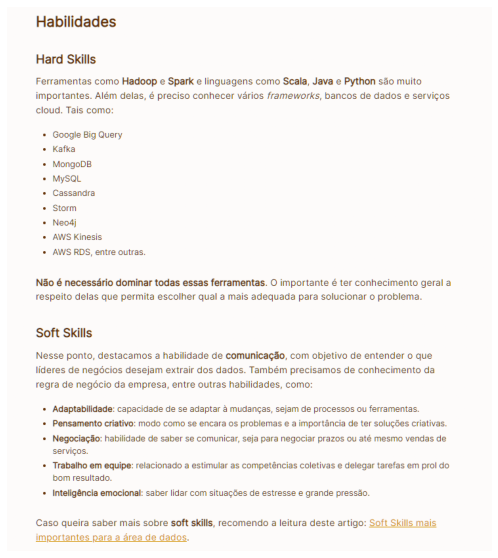

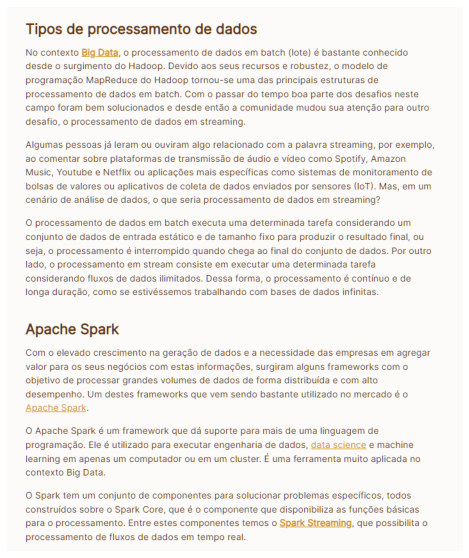

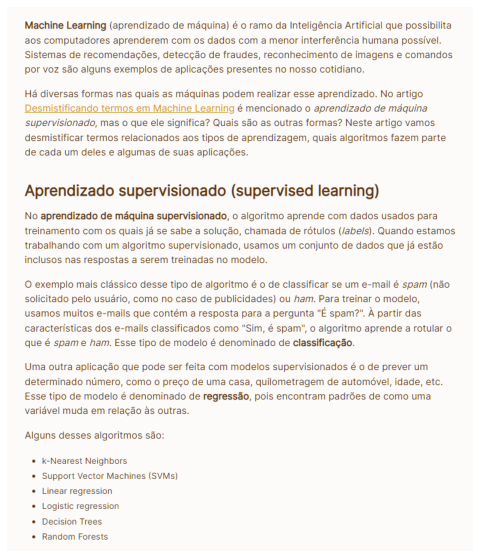

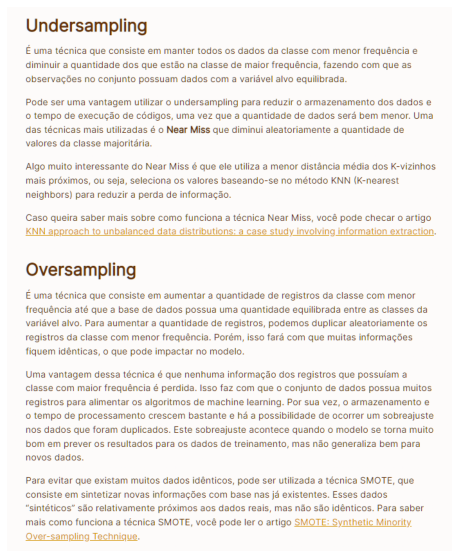

In [7]:
for imagem in caminho:
    imagem = plt.imread(imagem)
    mostrar(imagem)

In [8]:
config_tesseract = "/usr/share/tesseract-ocr/4.00/tessdata"

def OCR_processa(img, config_tesseract):
  texto = pytesseract.image_to_string(img, lang='por', config=config_tesseract)
  return texto

# Reconhecimento das imagens

In [9]:
texto_completo = ''
nome_txt = 'resultados_ocr.txt'

In [10]:
for imagem in caminho: # percorre as imagens no caminho
  img = cv2.imread(imagem) 
  nome_imagem = os.path.split(imagem)[-1] ## recebe os nomes e diretórios das imagens, quebrados, precisamos apenas do -1 (última posição do diretório)
  nome_divisao = '===================\n' + str(nome_imagem) #divisão + nome da imagem que está sendo vista
  texto_completo = texto_completo + nome_divisao + '\n' # recebe o texto completo + a divisão + /n para pular a linha
  texto = OCR_processa(img, config_tesseract) #passa a imagem que vamos utilizar, no caso em cada imagem
  texto_completo = texto_completo + texto # concatena as duas variáveis

In [11]:
texto_completo

'===================\nartigo-eng-dados.png\nHabilidades\n\nHard Skills\n\nFerramentas como Hadoop e Spark e linguagens como Scala, Java e Python são muito\nimportantes. Além delas, é preciso conhecer vários frameworks, bancos de dados e serviços\ncloud. Tais como:\n\n+ Google Big Query\n* Kafka\n\n+ MongoDB\n\n* MysaL\n\n+ Cassandra\n\n+ Storm\n\n* Neo4j\n\n+ AWS Kinesis\n\n+ AWS RDS, entre outras.\n\nNão é necessário dominar todas essas ferramentas. O importante é ter conhecimento geral a\nrespeito delas que permita escolher qual a mais adequada para solucionar o problema.\n\nSoft Skills\n\nNesse ponto, destacamos a habilidade de comunicação, com objetivo de entender o que\nlíderes de negócios desejam extrair dos dados. Também precisamos de conhecimento da\nregra de negócio da empresa, entre outras habilidades, como:\n\n+ Adaptabilidade: capacidade de se adaptar à mudanças, sejam de processos ou ferramentas.\n\n+ Pensamento criativo: modo como se encara os problemas e a importância de

In [12]:
## Salvando o arquivo em txt
arquivo_txt = open(nome_txt, 'w+') # a+ é para colocar no final do arquivo, w+ para sobre escrever o arquivo
arquivo_txt.write(texto_completo + '\n') #passa o texto que quer adicionar
arquivo_txt.close()

# Busca de ocorrências

In [13]:
termo_pesquisa = 'learning'

In [14]:
with open(nome_txt) as f: # abre o documento txt
  ocorrencias = [i.start() for i in re.finditer(termo_pesquisa, f.read())] #ocorrencia é uma lista. 
  #inicia-se em i e o termo re é de expressões regulares, o módulo finditer é para encontrar um termo de pesquisa dentro do arquivo
  #por isso os parâmetros são, respectivamente, termo_pesquisa e arquivo a ser lido.

In [15]:
ocorrencias

[3409, 4632, 7488]

## Na listagem de imagens

In [16]:
for imagem in caminho:
  img = cv2.imread(imagem) #carrega a imagem
  nome_imagem = os.path.split(imagem)[-1] # passa a imagem e acessa a última posição do diretório
  print('====================\n' + str(nome_imagem)) # separação + nome da imagem

  texto = OCR_processa(img, config_tesseract) #usando o OCR

  ocorrencias = [i.start() for i in re.finditer(termo_pesquisa, texto)] #usando o finditer novamente no texto

  print('Número de ocorrências para o termo: {}: {}'.format(termo_pesquisa, len(ocorrencias))) 
  #primeira chaves é para termo de pesquisa e a segunda é para ocorrencias
  print('\n')

artigo-eng-dados.png
Número de ocorrências para o termo: learning: 0


artigo-spark.png
Número de ocorrências para o termo: learning: 1


artigo-termos-ML.png
Número de ocorrências para o termo: learning: 1


artigo-desbalanceamento.png
Número de ocorrências para o termo: learning: 1




# Reconhecimento na imagem

In [17]:
fonte_dir = 'Imagens/calibri.ttf'

In [18]:
def escreve_texto(texto, x, y, img, fonte_dir, cor=(50, 50, 255), tamanho=16):
  fonte = ImageFont.truetype(fonte_dir, tamanho)
  img_pil = Image.fromarray(img) 
  draw = ImageDraw.Draw(img_pil) 
  draw.text((x, y-tamanho), texto, font = fonte, fill = cor) 
  img = np.array(img_pil) 

  return img

In [19]:
min_conf = 30

In [20]:
def caixa_texto(i, resultado, img, cor=(255, 100, 0)):
  x = resultado["left"][i]
  y = resultado["top"][i]
  w = resultado["width"][i]
  h = resultado["height"][i]
    
  cv2.rectangle(img, (x, y), (x + w, y + h), cor, 2)

  return x, y, img

In [22]:
def OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf):
  resultado = pytesseract.image_to_data(img, config=config_tesseract, lang='por', output_type=Output.DICT) #imagem para dados, que já fizemos anteriormente
  num_ocorrencias = 0 #inicializando como 0

  for i in range(0, len(resultado['text'])): # vai de 0 ao tamanho do número de valores do texto
    confianca = int(resultado['conf'][i]) # qual a confiança da detecção
    if confianca > min_conf: # se a confiança for maior que o valor mínimo, passa para a linha abaixo
      texto = resultado['text'][i] #texto será igual ao resultado text no momento i 
      if termo_pesquisa in texto: #se o termo de pesquisa estiver no texto:
        x, y, img = caixa_texto(i, resultado, img, (0,0,255)) # faz a caixa de bounding box
        img = escreve_texto(texto, x, y, img, fonte_dir, (50,50,225), 14) #escreve o texto 
        
        num_ocorrencias += 1 #faz a iteração no num de ocorrências e volta para o laço até acabar o texto
  return img, num_ocorrencias

artigo-eng-dados.png
Número de ocorrências para learning em artigo-eng-dados.png: 0




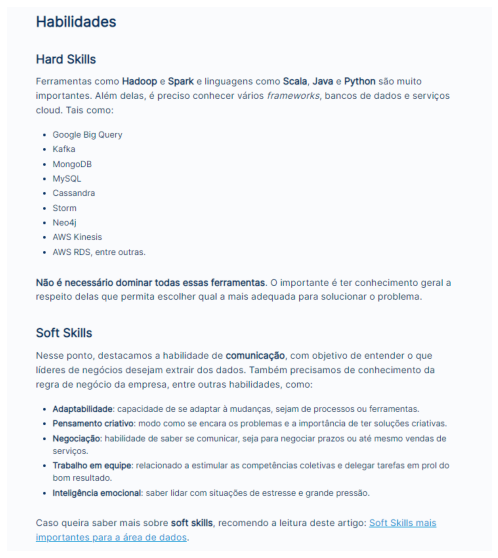

artigo-spark.png
Número de ocorrências para learning em artigo-spark.png: 1




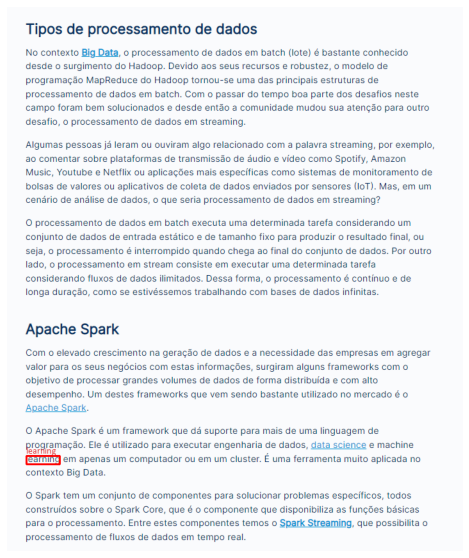

artigo-termos-ML.png
Número de ocorrências para learning em artigo-termos-ML.png: 1




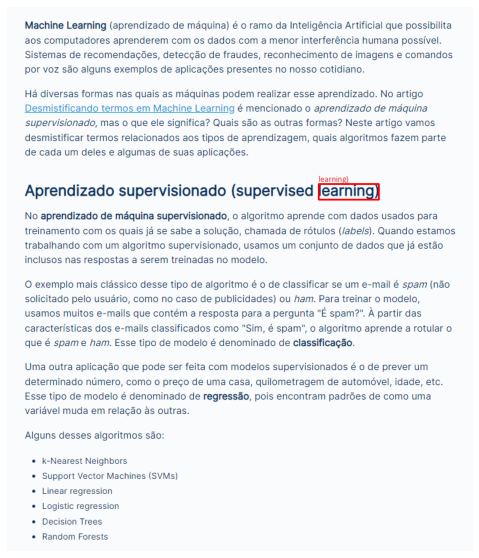

artigo-desbalanceamento.png
Número de ocorrências para learning em artigo-desbalanceamento.png: 1




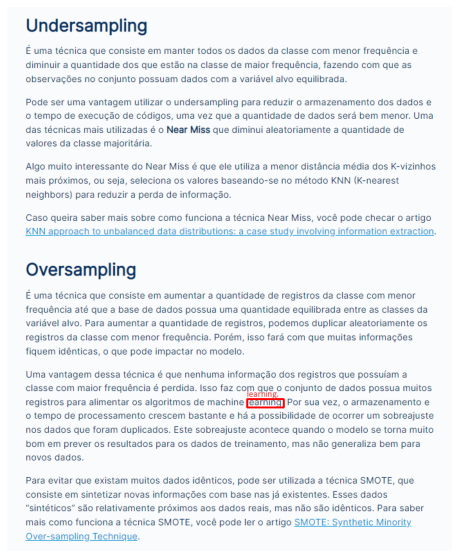

In [23]:
termo_pesquisa = 'learning'

for imagem in caminho:
  img = cv2.imread(imagem) #carrega a imagem
  img_original = img.copy() #cria uma cópia da imagem para não escrever em cima da original

  nome_imagem = os.path.split(imagem)[-1] # passa a imagem e acessa a última posição do diretório
  print('===================\n' + str(nome_imagem))  # separação + nome da imagem

  img, numero_ocorrencias = OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf) #usando o OCR_processa_imagem
  print('Número de ocorrências para {} em {}: {}'.format(termo_pesquisa, nome_imagem, numero_ocorrencias))
    #primeira chaves é para termo de pesquisa e a segunda nome das imagens e a terceira é o numeros de ocorrencias
  print('\n')

  mostrar(img)

## Reconhecendo maiusculas e minusculas

In [24]:
def OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf):
  resultado = pytesseract.image_to_data(img, config=config_tesseract, lang='por', output_type=Output.DICT) #imagem para dados, que já fizemos anteriormente
  num_ocorrencias = 0 #inicializando como 0

  for i in range(0, len(resultado['text'])): # vai de 0 ao tamanho do número de valores do texto
    confianca = int(resultado['conf'][i]) # qual a confiança da detecção
    if confianca > min_conf: # se a confiança for maior que o valor mínimo, passa para a linha abaixo
      texto = resultado['text'][i] #texto será igual ao resultado text no momento i 
      if termo_pesquisa.lower() in texto.lower(): #se o termo de pesquisa estiver no texto:
        x, y, img = caixa_texto(i, resultado, img, (0,0,255)) # faz a caixa de bounding box
        img = escreve_texto(texto, x, y, img, fonte_dir, (50,50,225), 14) #escreve o texto 
        
        num_ocorrencias += 1 #faz a iteração no num de ocorrências e volta para o laço até acabar o texto
  return img, num_ocorrencias

artigo-eng-dados.png
Número de ocorrências para learning em artigo-eng-dados.png: 0




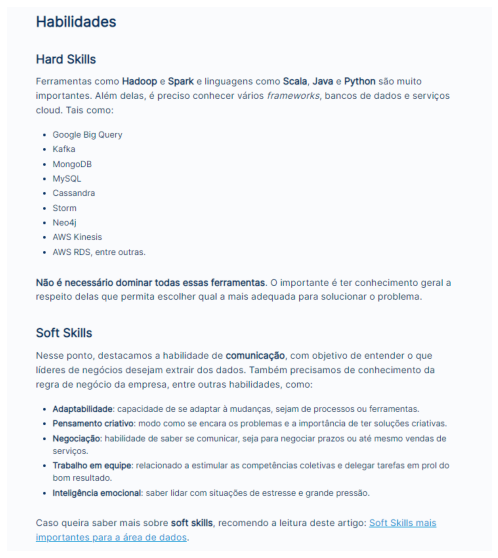

artigo-spark.png
Número de ocorrências para learning em artigo-spark.png: 1




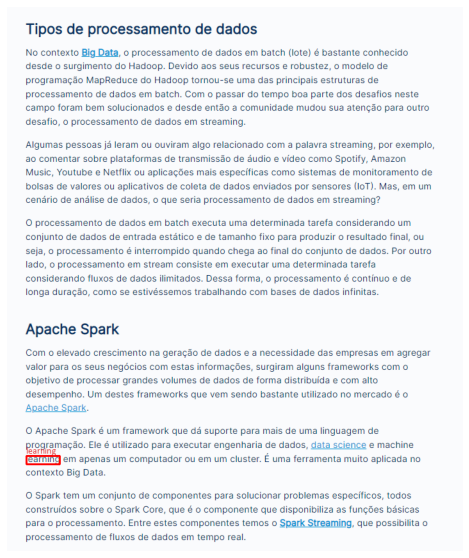

artigo-termos-ML.png
Número de ocorrências para learning em artigo-termos-ML.png: 3




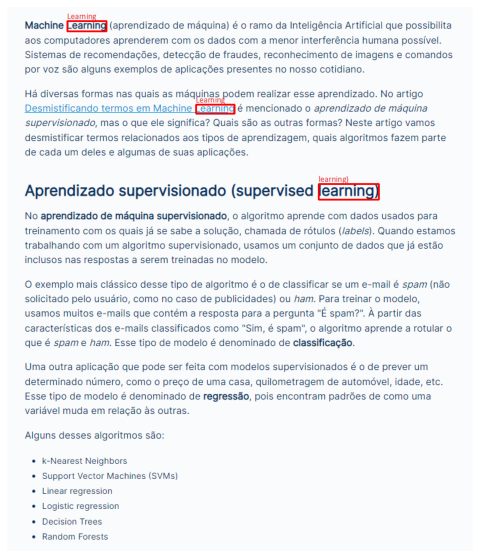

artigo-desbalanceamento.png
Número de ocorrências para learning em artigo-desbalanceamento.png: 1




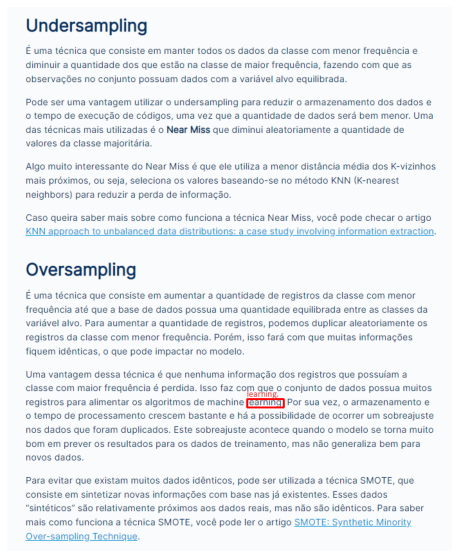

In [25]:
termo_pesquisa = 'learning'

for imagem in caminho:
  img = cv2.imread(imagem) #carrega a imagem
  img_original = img.copy() #cria uma cópia da imagem para não escrever em cima da original

  nome_imagem = os.path.split(imagem)[-1] # passa a imagem e acessa a última posição do diretório
  print('===================\n' + str(nome_imagem))  # separação + nome da imagem

  img, numero_ocorrencias = OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf) #usando o OCR_processa_imagem
  print('Número de ocorrências para {} em {}: {}'.format(termo_pesquisa, nome_imagem, numero_ocorrencias))
    #primeira chaves é para termo de pesquisa e a segunda nome das imagens e a terceira é o numeros de ocorrencias
  print('\n')

  mostrar(img)